In [1]:
import os
import cv2
import glob
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
!%tensorflow_version 1.x

/bin/sh: 1: %tensorflow_version: not found


In [3]:
!pip install -q keras-segmentation

In [4]:
from keras_segmentation.models.unet import vgg_unet

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [5]:
# !rm -rf /content/datasets
# !git clone https://github.com/tailtq/datasets

In [6]:
# !ls /content/datasets/
# !pwd

In [7]:
!pip show tensorflow

In [8]:
# !pip uninstall tensorflow --y
# !pip install tensorflow==1.14

## Visualize images

In [9]:
path = Path('../../../../datasets/camvid')

In [10]:
label_path = path / 'codes.txt'
valid_path = path / 'valid.txt'

In [11]:
labels = np.loadtxt(label_path, dtype=str)
val_files = np.loadtxt(valid_path, dtype=str)

labels

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [12]:
get_y_fn = lambda x: path/'labels/{0}_P{1}'.format(x.stem, x.suffix)

In [13]:
img_paths = [
    '0001TP_006690.png',
    '0016E5_00570.png',
    '0016E5_08047.png',
    'Seq05VD_f03540.png',
    'Seq05VD_f03540.png',
    'Seq05VD_f04560.png'
]

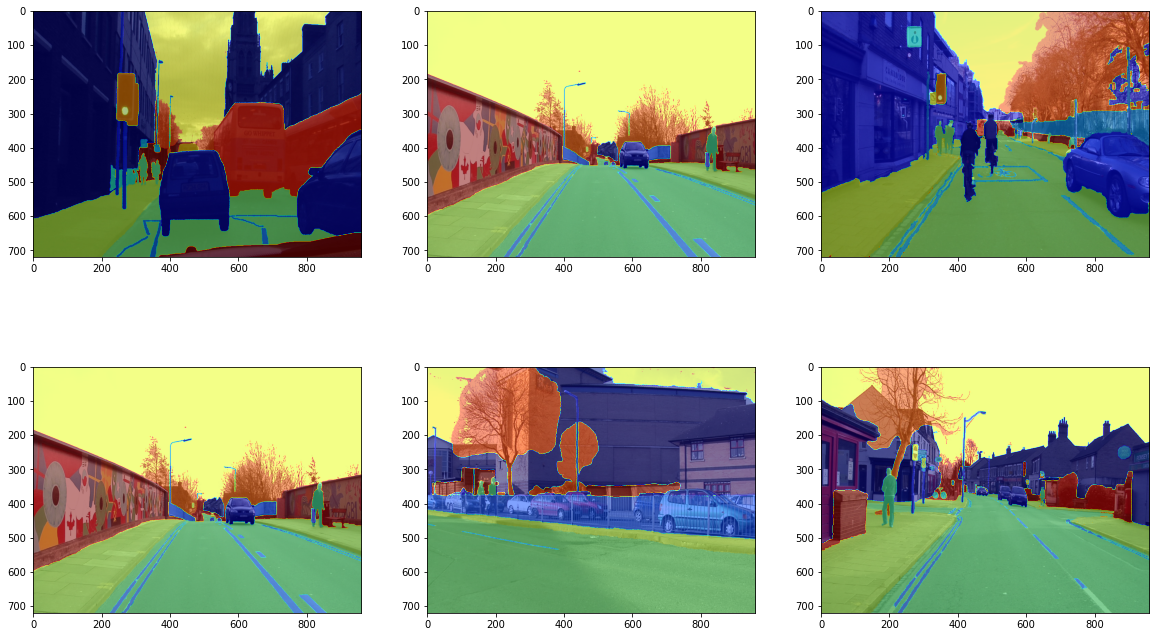

In [14]:
c_map = 'jet'

fig, ax = plt.subplots(2, 3, figsize=(20, 12))

for i in range(len(img_paths)):
    img_path = path / 'images' / img_paths[i]
    lb_path = get_y_fn(img_path)
    img = Image.open(img_path, 'r')
    lb = Image.open(lb_path, 'r')

    ax[i%2][i%3].imshow(np.asarray(img))
    ax[i%2][i%3].imshow(np.asarray(lb), cmap=c_map, alpha=0.5)

In [15]:
# size = (256, 192)
size = (480, 352)
size_dir = '_' + str(size[0])

  4%|▎         | 22/600 [00:00<00:02, 214.77it/s]

Verifying training dataset


100%|██████████| 600/600 [00:02<00:00, 218.66it/s]


Dataset verified! 
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/5
512/512 [==============================] - 477s 931ms/step - loss: 1.4409 - accuracy: 0.6173
Epoch 2/5
512/512 [==============================] - 382s 746ms/step - loss: 1.0540 - accuracy: 0.7156
Epoch 3/5
512/512 [==============================] - 386s 754ms/step - loss: 0.8488 - accuracy: 0.7776
Epoch 4/5
512/512 [==============================] - 382s 746ms/step - loss: 0.7306 - accuracy: 0.8087
Epoch 5/5
512/512 [==============================] - 383s 749ms/step - loss: 0.6663 - accuracy: 0.8257


101it [00:14,  6.85it/s]


{'frequency_weighted_IU': 0.4598933651425558, 'mean_IU': 0.10622532873620005, 'class_wise_IU': array([0.00000000e+00, 0.00000000e+00, 3.67047308e-03, 0.00000000e+00,
       5.58987215e-01, 3.50454299e-01, 0.00000000e+00, 7.51455946e-04,
       4.13290377e-02, 8.39574185e-02, 2.25243537e-01, 0.00000000e+00,
       1.57688590e-03, 0.00000000e+00, 4.26652547e-02, 1.67706095e-02,
       1.04871011e-01, 5.60230662e-01, 1.58339198e-03, 6.66023274e-01,
       0.00000000e+00, 2.67935286e-03, 2.73327446e-03, 0.00000000e+00,
       6.08249217e-02, 0.00000000e+00, 6.39204250e-01, 4.90891240e-04,
       0.00000000e+00, 1.36184121e-02, 1.09038972e-02, 1.06409945e-02])}


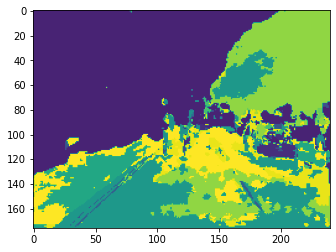

In [16]:
model = vgg_unet(n_classes=len(labels), input_width=size[0], input_height=size[1])

model.train(
    train_images=str(path/f'train/images{size_dir}'),
    train_annotations=str(path/f'train/labels{size_dir}'),
    epochs=5
)

out = model.predict_segmentation(
    inp=str(path/f'test/images{size_dir}/0016E5_07959.png'),
    out_fname='/content/out.png'
)
plt.imshow(out)

# evaluating the model 
print(model.evaluate_segmentation(inp_images_dir=str(path/f'test/images{size_dir}'), annotations_dir=str(path/f'test/labels{size_dir}')))

### 5 more epochs

In [24]:
model.train(
    train_images=str(path/f'train/images{size_dir}'),
    train_annotations=str(path/f'train/labels{size_dir}'),
    epochs=5
)

  4%|▍         | 26/600 [00:00<00:02, 251.02it/s]

Verifying training dataset


100%|██████████| 600/600 [00:02<00:00, 244.69it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - 325s 636ms/step - loss: 0.6450 - accuracy: 0.8308
Epoch 2/5
512/512 [==============================] - 352s 687ms/step - loss: 0.5746 - accuracy: 0.8493
Epoch 3/5
512/512 [==============================] - 361s 706ms/step - loss: 0.5317 - accuracy: 0.8604
Epoch 4/5
512/512 [==============================] - 369s 720ms/step - loss: 0.4963 - accuracy: 0.8694
Epoch 5/5
512/512 [==============================] - 374s 731ms/step - loss: 0.4674 - accuracy: 0.8776


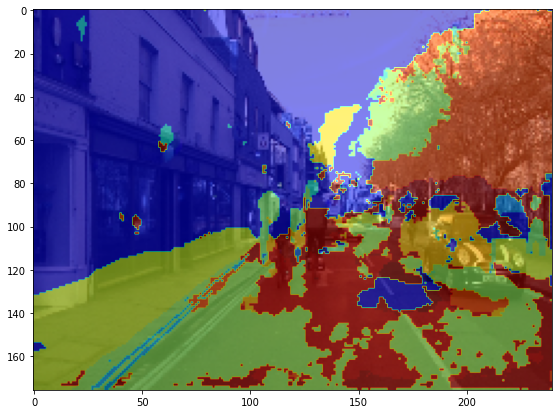

In [34]:
out_path = str(path/f'test/images{size_dir}/0016E5_07959.png'
out = model.predict_segmentation(
    inp=out_path,
    out_fname='/content/out1.png'
)
out_image = cv2.imread(str(path/f'test/images_256/0016E5_07959.png'))
out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.imshow(out_image)
ax.imshow(out, cmap=c_map, alpha=0.5)

In [35]:
model.train(
    train_images=str(path/f'train/images{size_dir}'),
    train_annotations=str(path/f'train/labels{size_dir}'),
    epochs=5
)

  4%|▍         | 25/600 [00:00<00:02, 248.27it/s]

Verifying training dataset


100%|██████████| 600/600 [00:02<00:00, 248.96it/s]


Dataset verified! 
Epoch 1/5
512/512 [==============================] - 338s 661ms/step - loss: 0.4836 - accuracy: 0.8725
Epoch 2/5
512/512 [==============================] - 358s 700ms/step - loss: 0.4206 - accuracy: 0.8903
Epoch 3/5
512/512 [==============================] - 366s 715ms/step - loss: 0.3838 - accuracy: 0.9007
Epoch 4/5
512/512 [==============================] - 372s 726ms/step - loss: 0.3615 - accuracy: 0.9066
Epoch 5/5
512/512 [==============================] - 371s 726ms/step - loss: 0.3487 - accuracy: 0.9100


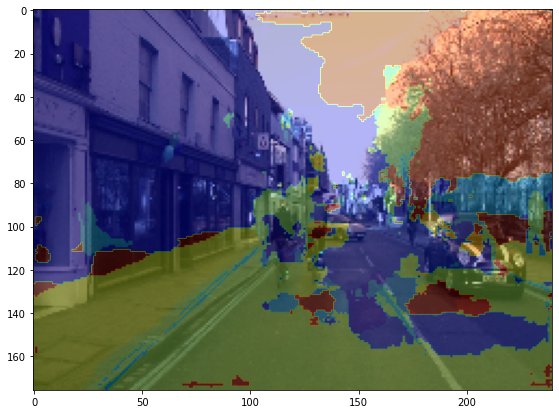

In [40]:
out_path = str(path/f'test/images{size_dir}/0016E5_07959.png')
out = model.predict_segmentation(
    inp=out_path,
    out_fname='/content/out1.png'
)
out_image = cv2.imread(str(path/f'test/images_256/0016E5_07959.png'))
out_image = cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.imshow(out_image)
ax.imshow(out, cmap=c_map, alpha=0.3)

In [41]:
model.save('model.h5')